# Визуализация решающих деревьев.

В этом ноутбуке будет рассмотрена библиотека `graphviz` и будет показано, как с её помощью можно визуализировать решающие деревья.

Для установки библиотеки через pip:
```bash
pip install graphiz
```

Для установки библиотеки через conda:
```bash
conda install -c conda-forge python-graphiz 
```

In [1]:
import pandas as pd
import numpy as np
import graphviz
from sklearn import tree

В качестве данных возьмём [датасет с Kaggle](https://www.kaggle.com/crawford/1000-cameras-dataset/download) по определению цены камеры по её имеющимся характеристикам.

К её характеристикам относятся:

* `Release date` — дата выпуска,

* `Max resolution` — максимальное разрешение,

* `Low resolution` — нижнее разрешение,

* `Effective pixels` — число эффективных пикселей, 

* `Zoom wide (W)` — ширина зума,

* `Zoom tele (T)` — телезум,

* `Normal focus range` — нормальный фокусный диапазон,

* `Macro focus range` — макрофокусный диапазон,

* `Storage included` — встроенный объём памяти,

* `Weight (inc. batteries)` — вес,

* `Dimensions` — габариты.

Для того, чтобы деревья не получались слишком широкими, будем их обучать на небольшой части датасета

In [2]:
camera_df = pd.read_csv('camera_dataset.csv')[:100]
camera_df = camera_df.drop('Model', axis=1)

print(camera_df.shape)
camera_df.head()

(100, 12)


,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


Вспомним, какие основные признаки есть у решающего дерева.

* `criterion` — критерий информативности, по которому происходит разбиение вершины дерева. 

* `max_depth` — ограничение на глубину дерева.

* `min_samples_split` — минимальное количество элементов обучающей выборки в вершине дерева, чтобы её можно было разбивать.

* `min_samples_leaf` — минимальное количество элементов обучающей выборке в листовой вершине.

* `splitter` — способ разбиения вершины каждого решающего дерева. Есть 2 возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

* `max_features` — максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением дерева генерируется выборка из `min(k, max_features)` случайных признаков, где `k` — количество признаков в датасете, и только эти признаки рассматриваются как разделяющие в данной вершине. <br> 
`max_features` может принимать:
  + целочисленное значение (число признаков), 
  + вещественное значение (доля признаков), 
  + None (все признаки), 
  + "auto" (квадратный корень от числа всех признаков), 
  +  "sqrt" (квадратный корень от числа всех признаков), 
  + "log2" (двоичный логарифм от числа всех признаков).
Стандартное значение — "auto".



Посмотрим, как меняется изображение дерева при различных значениях параметров `max_depth`, `mean_samples_split`, `max_features`. 

In [3]:
X, y = camera_df.loc[:, camera_df.columns != 'Price'], camera_df['Price']

In [4]:
def get_graphviz_graph(decision_tree_regressor):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    
    decision_tree_regressor.fit(X, y)
    dot_data = tree.export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=X.columns, class_names='Price',  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)  

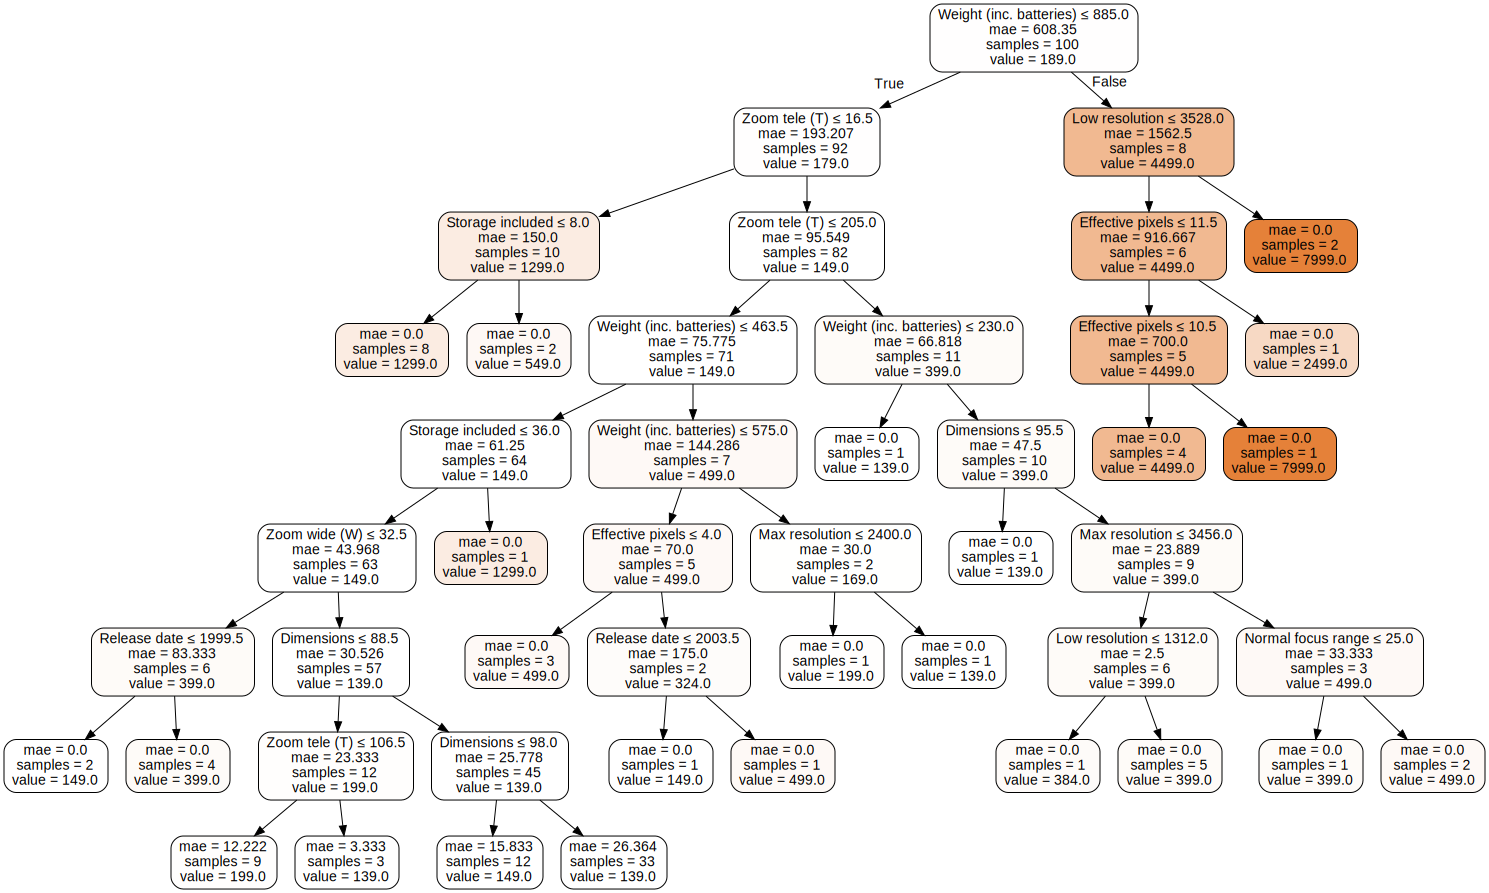

In [5]:
camera_regressor = tree.DecisionTreeRegressor(
    criterion='mae', max_depth=8, min_samples_split=2
)
graph = get_graphviz_graph(camera_regressor)
graph

В дереве довольно много листовых вершин с <= 2 элементами. Это приводит к неустойчивости предсказаний. 

Увеличим минимальное количество элементов для разбивания вершины.

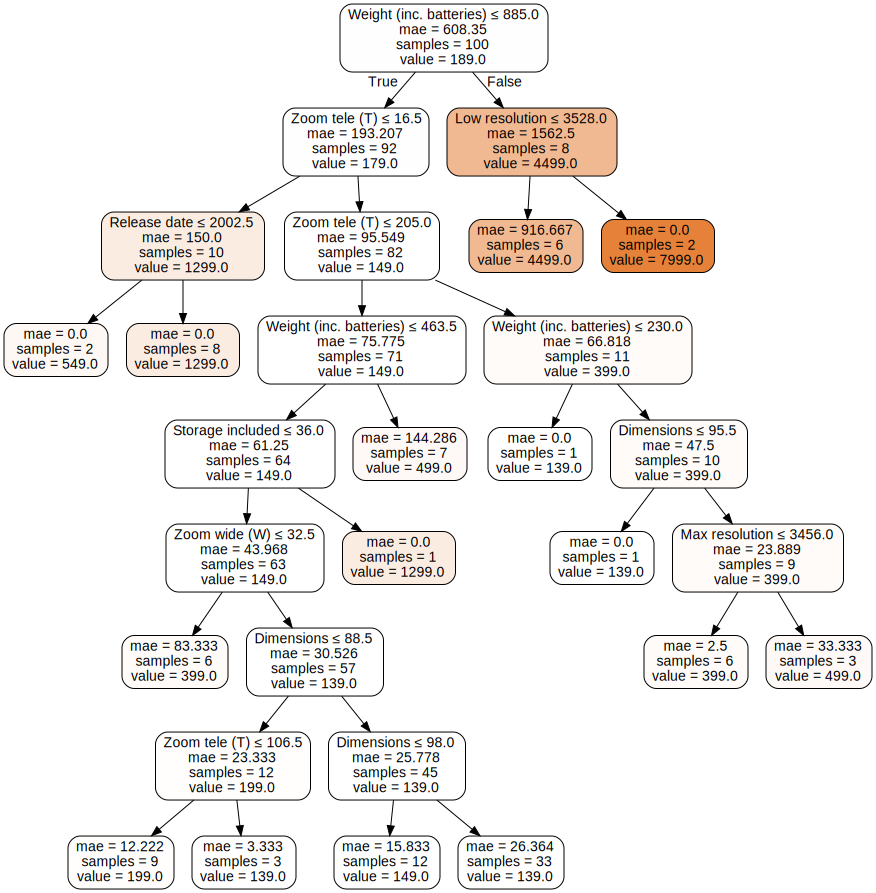

In [6]:
camera_regressor = tree.DecisionTreeRegressor(
    criterion='mae', max_depth=8, min_samples_split=8
)
graph = get_graphviz_graph(camera_regressor)
graph

Немного увеличим глубину дерева и минимальный размер листа.

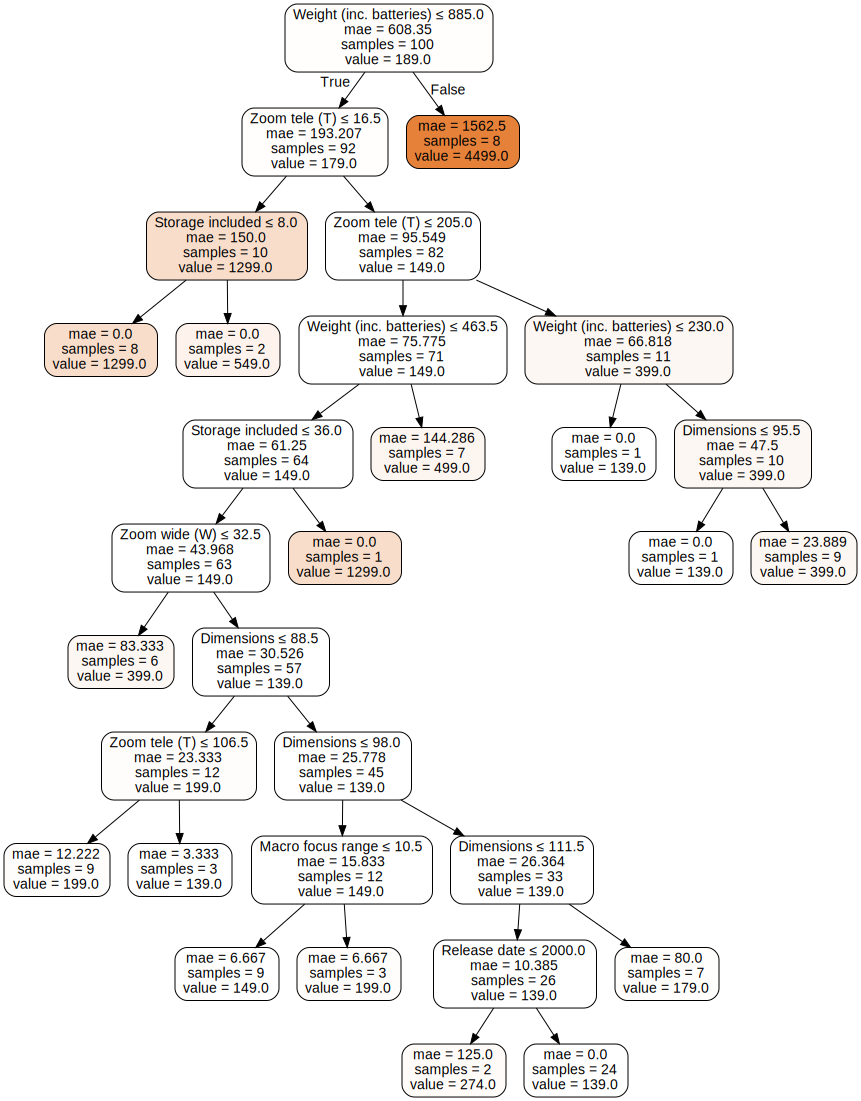

In [7]:
camera_regressor = tree.DecisionTreeRegressor(
    criterion='mae', max_depth=10, min_samples_split=10
)
graph = get_graphviz_graph(camera_regressor)
graph

Рассмотрим менее глубокое дерево.

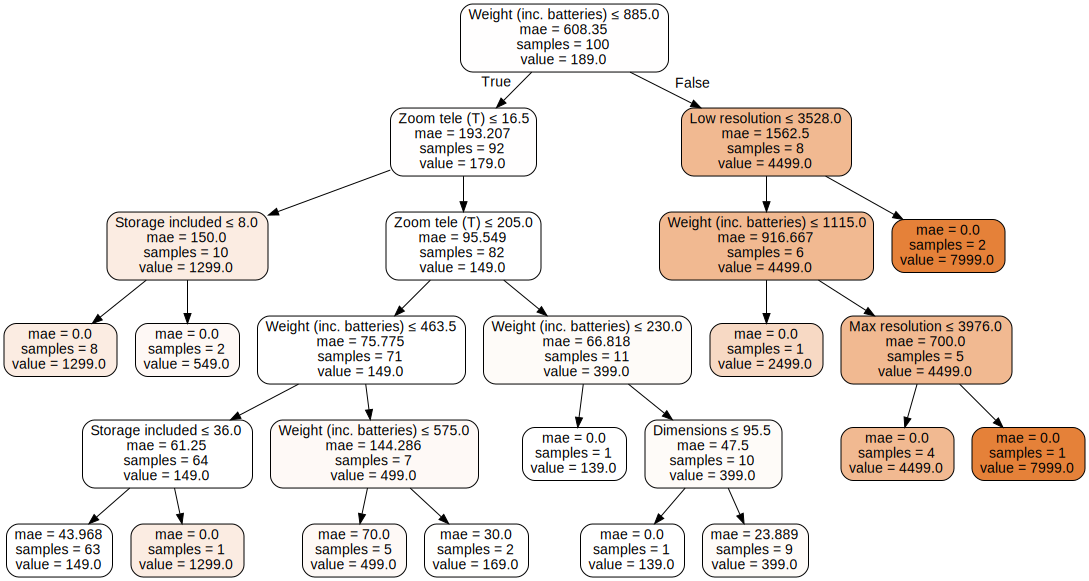

In [8]:
camera_regressor = tree.DecisionTreeRegressor(
    criterion='mae', max_depth=5, min_samples_split=2
)
graph = get_graphviz_graph(camera_regressor)
graph

Увеличим максимально возможную глубину дерева, сохранив значения всех остальных параметров с прошлого запуска.

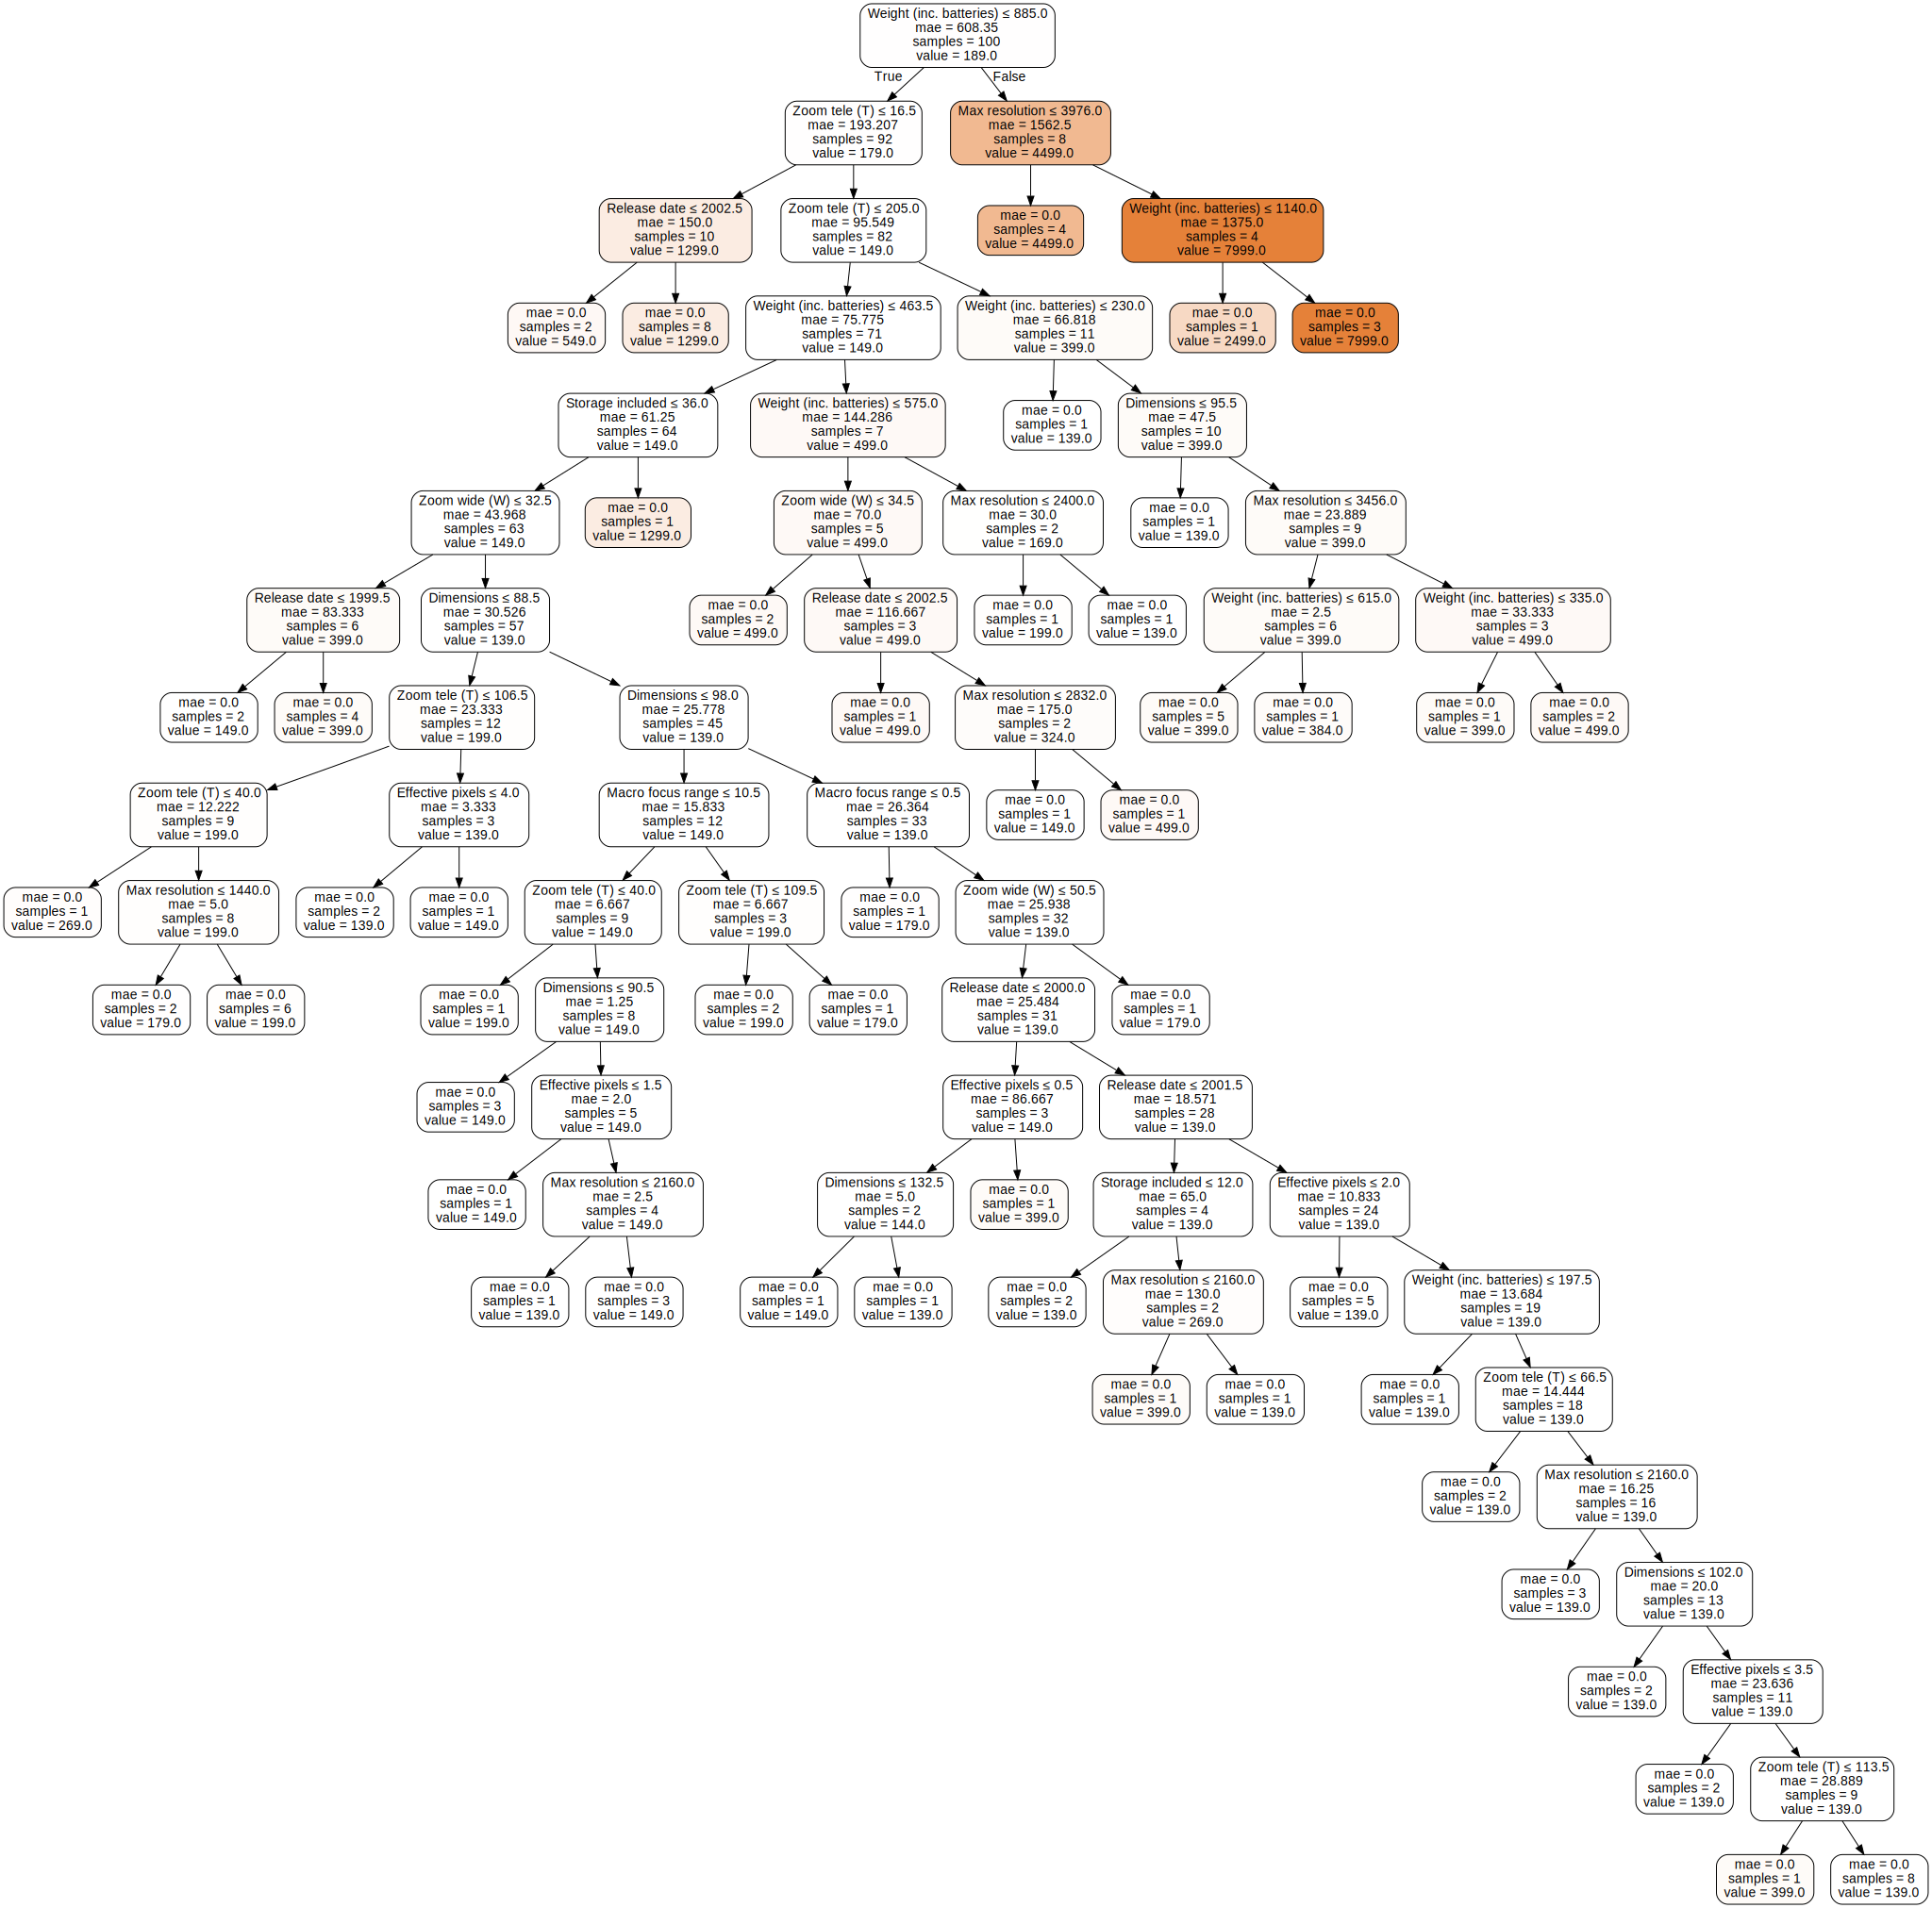

In [9]:
camera_regressor = tree.DecisionTreeRegressor(
    criterion='mae', max_depth=20, min_samples_split=2
)
graph = get_graphviz_graph(camera_regressor)
graph

### Выводы

 По построенной визуализации дерева можно увидеть, что большая часть разбиений вершин вполне соотносится со здравым смыслом и логикой принятия решений человеком. Например, чем больше zoom камеры, тем больше должна быть цена при прочих равных или чем больше встроенной памяти имеет камера, тем больше должна быть её цена.

 При этом при варьировании параметра `min_samples_split` наблюдается такая закономерность: чем больше значение `min_samples_split`, тем меньше глубина дерева, но само дерево шире. Аналогичная ситуация происходит и при уменьшении значения `max_depth`.

 Логично брать в качестве значения `max_depth` $\min(\text{features_count}, \text{log}_2 n)$, `min_samples_split` около 5 и потом подбирать в их окрестности оптимальные параметры по кросс-валидации. В любом случае предварительный выбор параметров стоит делать, опираясь прежде всего на размер датасета и количество признаков в нём. 

Из проделанной работы можем сделать вывод, что решающее дерево — действительно хорошо интерпретируемая модель и при достаточно чистых данных оно может дать весьма логичную систему принятия решений.